**Training a Neural Network**

**Goals:**
* Select any dataset previously introduced in the course.
* Build and train a Neural Network to solve a problem typically addressed by atraditional data science method (e.g., classification, regression).
* Compare the performance and approach of your Neural Network to the conventional method.

In [1]:
# Install Some Dependancies
!pip install statsbombpy --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 1.2 MB/s eta 0:00:00


**Introduction:**

We will be using statsbomb data from the 2020/21 FA Women's Super Leagueto compare the performance and approach of a neural network to a logistic regression.

In [2]:
# Step 1: Import Libraries

# Install Some Dependancies for the Lab
!pip install statsbombpy --quiet
!pip install mplsoccer --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsbombpy import sb
from mplsoccer import Sbopen

# Some code to suppress warnings about not using an API key – we're using the free dataset
from statsbombpy.api_client import NoAuthWarning
import warnings
warnings.filterwarnings('ignore', category=NoAuthWarning)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, brier_score_loss, log_loss,
    roc_curve, auc, accuracy_score
)
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 3.6 MB/s eta 0:00:00


In [3]:
# Step 2: Load Data

league = {
  'competition_id': 37,
  'season_id': 90,
  'country_name': 'England',
  'competition_name': "FA Women's Super League",
  'season_name': '2020/2021'
}

# Load all matches for the Women's Super League (2020/21)
matches = sb.matches(
    competition_id=league['competition_id'],
    season_id=league['season_id']
)

# Load events for all matches and concatenate into one dataframe
all_events = []
for match_id in matches['match_id']:
    events = sb.events(match_id=match_id)
    all_events.append(events)
events_df = pd.concat(all_events, ignore_index=True)

# Filter to shots only
shots_df = events_df[events_df['type'] == 'Shot'].copy()

# Shot location
shots_df['x'] = shots_df['location'].apply(lambda x: x[0])
shots_df['y'] = shots_df['location'].apply(lambda x: x[1])

# Distance from center of goal (120, 40)
shots_df['shot_distance'] = np.sqrt((120 - shots_df['x'])**2 + (40 - shots_df['y'])**2)

# Shot angle (simple version)
shots_df['shot_angle'] = np.arctan2(
    np.abs(shots_df['y'] - 40),
    120 - shots_df['x']
)

# Binary target: Goal or No Goal
shots_df['goal'] = (shots_df['shot_outcome'] == 'Goal').astype(int)

# Categorical encodings
shots_df['body_part'] = shots_df['shot_body_part'].astype(str)
shots_df['technique'] = shots_df['shot_technique'].astype(str)
shots_df['play_pattern'] = shots_df['play_pattern'].astype(str)

# One-hot encode categorical variables
shots_encoded = pd.get_dummies(
    shots_df[[
        'shot_distance',
        'shot_angle',
        'body_part',
        'technique',
        'play_pattern'
    ]],
    drop_first=True
)

# Final feature matrix (X) and target (y)
X = shots_encoded.values
y = shots_df['goal'].values

In [4]:
# Step 3: Train / VAL / Test Split (60 / 20 / 20)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42
)


In [5]:
# Step 4: Normalization

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

In [6]:
# Step 5: Neural Network Model

model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6557 - loss: 0.6124 - val_accuracy: 0.8938 - val_loss: 0.3550
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8620 - loss: 0.4087 - val_accuracy: 0.8923 - val_loss: 0.3293
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8689 - loss: 0.3597 - val_accuracy: 0.8923 - val_loss: 0.3189
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8595 - loss: 0.3711 - val_accuracy: 0.8923 - val_loss: 0.3133
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8811 - loss: 0.3132 - val_accuracy: 0.8954 - val_loss: 0.3113
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8757 - loss: 0.3198 - val_accuracy: 0.8938 - val_loss: 0.3096
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8816 - loss: 0.3125 - val_accuracy: 0.8938 - val_loss: 0.3116
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8761 - loss: 0.3113 - val_accuracy: 0.8938 - v

In [7]:
# Step 6: Neural Network Evaluation
y_pred_proba = model.predict(X_test).flatten()

roc_nn = roc_auc_score(y_test, y_pred_proba)
brier_nn = brier_score_loss(y_test, y_pred_proba)
ll_nn = log_loss(y_test, y_pred_proba)
acc_nn = accuracy_score(y_test, (y_pred_proba >= 0.5).astype(int))

print("\n===== Neural Network Results =====")
print("ROC-AUC:", roc_nn)
print("Brier Score:", brier_nn)
print("Log Loss:", ll_nn)
print("Accuracy:", acc_nn)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

===== Neural Network Results =====
ROC-AUC: 0.7581763785952268
Brier Score: 0.09086568442780805
Log Loss: 0.3201861590307397
Accuracy: 0.8846153846153846


In [8]:
# Step 7: Logistic Regression Baseline

log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train, y_train)

y_pred_proba_lr = log_reg.predict_proba(X_test)[:, 1]

roc_lr = roc_auc_score(y_test, y_pred_proba_lr)
brier_lr = brier_score_loss(y_test, y_pred_proba_lr)
ll_lr = log_loss(y_test, y_pred_proba_lr)
acc_lr = accuracy_score(y_test, (y_pred_proba_lr >= 0.5).astype(int))

print("\n===== Logistic Regression Results =====")
print("ROC-AUC:", roc_lr)
print("Brier Score:", brier_lr)
print("Log Loss:", ll_lr)
print("Accuracy:", acc_lr)



===== Logistic Regression Results =====
ROC-AUC: 0.7678769746832574
Brier Score: 0.08876621013499464
Log Loss: 0.3144442495723806
Accuracy: 0.8876923076923077


In [9]:
# Step 8: Comparison Table

results_df = pd.DataFrame({
    "Model": ["Neural Network", "Logistic Regression"],
    "ROC-AUC": [roc_nn, roc_lr],
    "Brier Score": [brier_nn, brier_lr],
    "Log Loss": [ll_nn, ll_lr],
    "Accuracy": [acc_nn, acc_lr]
})

print("\n===== Comparison Table =====")
print(results_df)


===== Comparison Table =====
                 Model   ROC-AUC  Brier Score  Log Loss  Accuracy
0       Neural Network  0.758176     0.090866  0.320186  0.884615
1  Logistic Regression  0.767877     0.088766  0.314444  0.887692


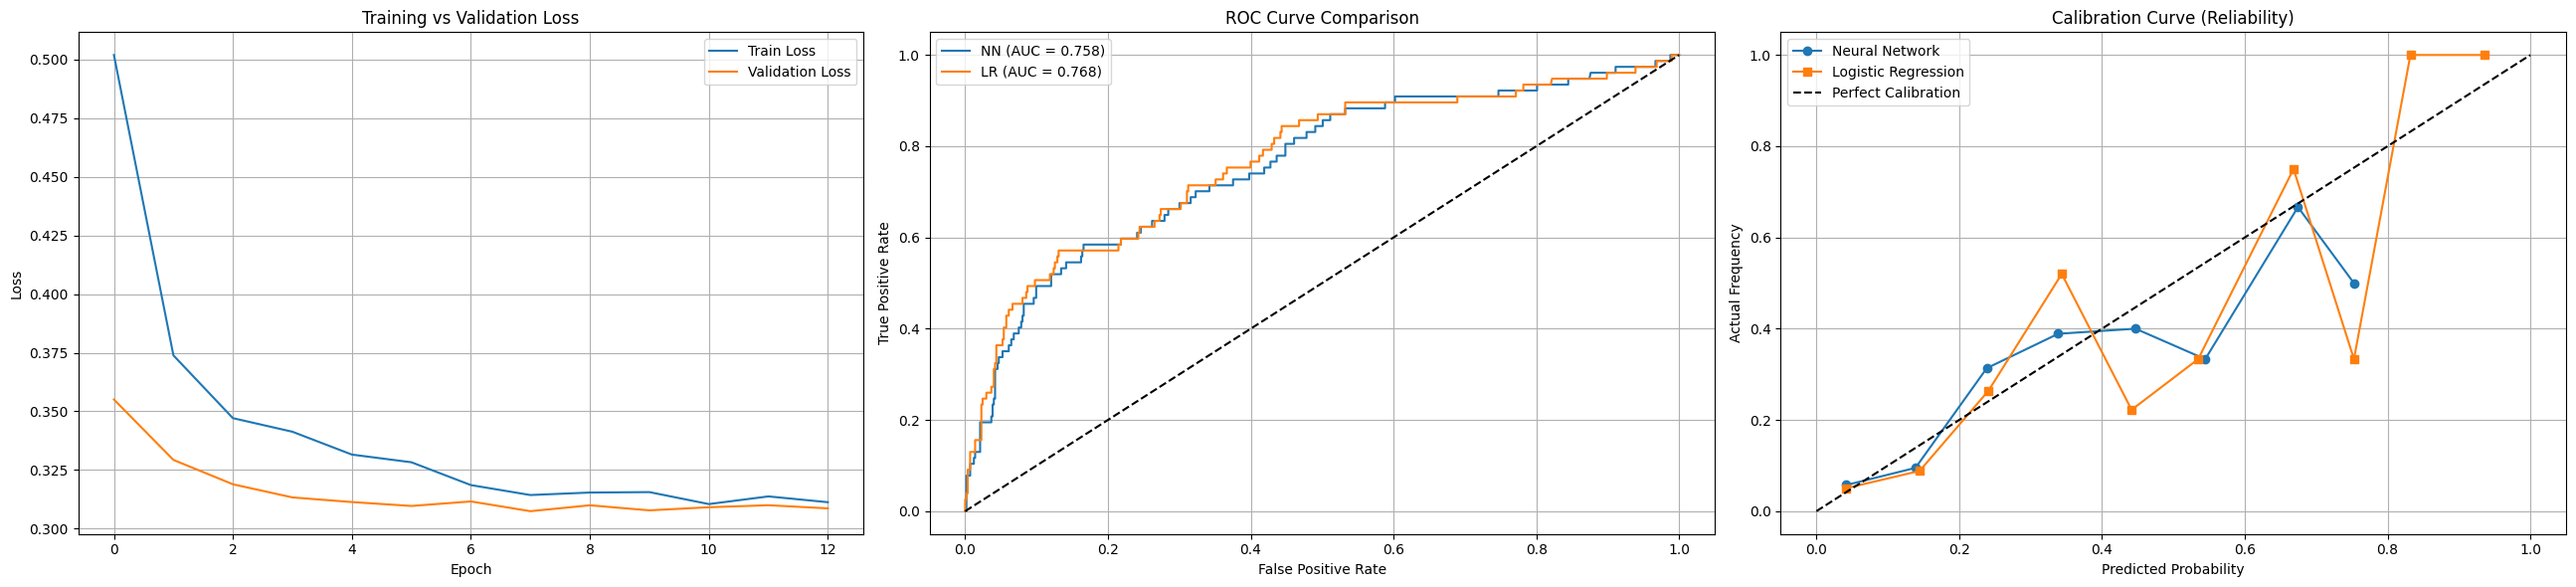

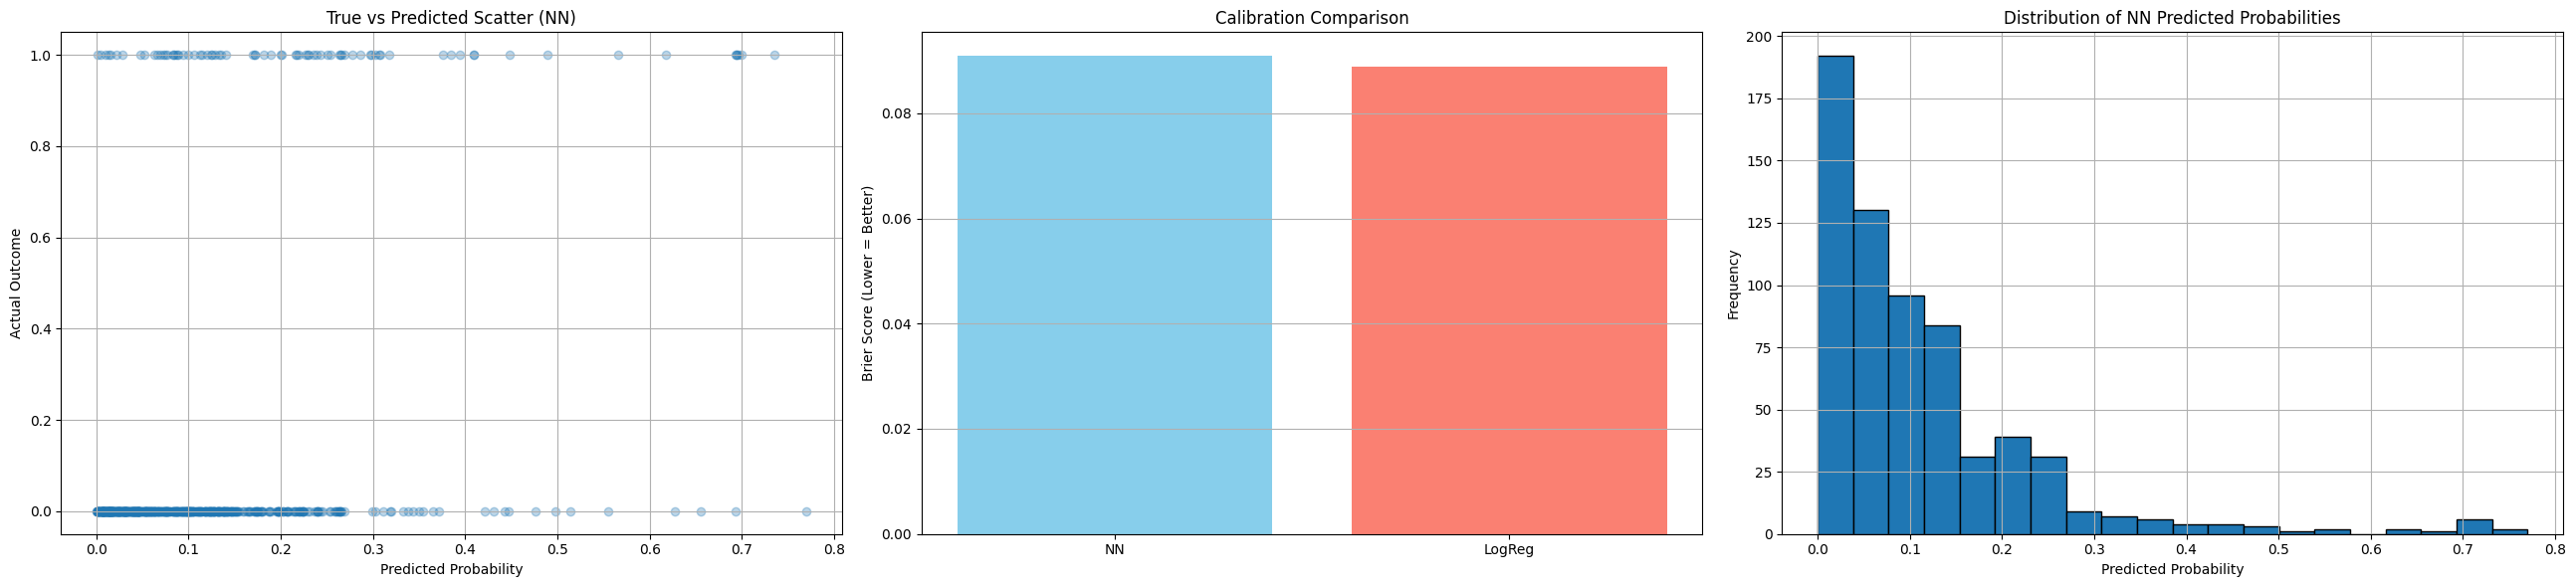

In [10]:
# Step 9: Visualizations

fig, axs = plt.subplots(1, 3, figsize=(26, 6))

# 1) Training vs Validation Loss
axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Training vs Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Calculate ROC curve points
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_proba)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)

# 2) ROC Curve (NN vs LR)
axs[1].plot(fpr_nn, tpr_nn, label=f"NN (AUC = {roc_nn:.3f})")
axs[1].plot(fpr_lr, tpr_lr, label=f"LR (AUC = {roc_lr:.3f})")
axs[1].plot([0,1], [0,1], 'k--')
axs[1].set_title("ROC Curve Comparison")
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")
axs[1].legend()
axs[1].grid(True)

# 3) Calibration Curve
prob_true_nn, prob_pred_nn = calibration_curve(y_test, y_pred_proba, n_bins=10)
prob_true_lr, prob_pred_lr = calibration_curve(y_test, y_pred_proba_lr, n_bins=10)

axs[2].plot(prob_pred_nn, prob_true_nn, marker='o', label="Neural Network")
axs[2].plot(prob_pred_lr, prob_true_lr, marker='s', label="Logistic Regression")
axs[2].plot([0,1], [0,1], 'k--', label='Perfect Calibration')
axs[2].set_title("Calibration Curve (Reliability)")
axs[2].set_xlabel("Predicted Probability")
axs[2].set_ylabel("Actual Frequency")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(26, 6))

# 4) True vs Predicted Scatter
axs[0].scatter(y_pred_proba, y_test, alpha=0.3)
axs[0].set_xlabel("Predicted Probability")
axs[0].set_ylabel("Actual Outcome")
axs[0].set_title("True vs Predicted Scatter (NN)")
axs[0].grid(True)

# 5) Brier Score Bar Comparison
axs[1].bar(["NN", "LogReg"], [brier_nn, brier_lr],
           color=["skyblue", "salmon"])
axs[1].set_ylabel("Brier Score (Lower = Better)")
axs[1].set_title("Calibration Comparison")
axs[1].grid(axis='y')

# 6) Histogram of Probabilities
axs[2].hist(y_pred_proba, bins=20, edgecolor='black')
axs[2].set_xlabel("Predicted Probability")
axs[2].set_ylabel("Frequency")
axs[2].set_title("Distribution of NN Predicted Probabilities")
axs[2].grid(True)

plt.tight_layout()
plt.show()

**Results + Discussion:**

In the comparison between the neural network and logistic regression, both models performed strongly with solid ability to distinguish between goals and non-goals. In this example, logistic regression marginally outperformed the neural network in discrimination, calibration, and log loss. Logistic regression assumes simple and direct relationships, uses fewer parameters, and is highly effective on tabular data. The neural network, in contrast, is nonlinear, more computationally demanding, and designed to capture more complex patterns. Because xG is a largely linear-friendly modeling problem—where variables like distance, angle, and body part follow smooth and predictable relationships—the logistic regression model is able to capture these patterns very effectively. Neural networks would be expected to outperform logistic regression only when the underlying patterns are more complex, such as when incorporating tracking data, defender positions, or richer contextual features.